<a href="https://colab.research.google.com/github/simon-pltk/AI4ALL-Portfolio-Movie-Recommender/blob/main/AI4ALL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Action Items:
1. Accounting for BIAS: Maybe take what we said in the document/slides to counteract the bias and then implement it. Such as taking from the TMDb API and adding more movies to the dataset with different languages/countries of origin. Also make sure the reccommendation is randomizing the movies on release year and is not biased towards earlier release years.
3. Getting a quantification of the tone indicators for each cluster
4. Figuring out maybe a better K-means
5. Get a heirarchal clustering approach or visualization
6. (Optional) Experiment outside of using vader

In [ ]:
!pip install kagglehub[pandas-datasets]
!pip install vaderSentiment
!pip install scikit-learn
!pip install qgrid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 889.2/889.2 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.4 MB/s eta 0:00:00
  Created wheel for qgrid: filename=qgrid-1.3.1-py2.py3-none-any.whl size=1761252 sha256=48477c23d0732430e904efd7238cd945c21b2724e70bf4aeb59d0c9a51be031f
  Stored in directory: /root/.cache/pip/wheels/7f/0f/d6/33b60aa35dbdc3d3e84c44b780c85e92d8767b698843f9e256
Successfully built qgrid


# Installing Necessary Dependencies and Loading Dataset

In [ ]:
# Install dependencies as needed:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import warnings
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA




file_path = "tmdb_5000_movies.csv"

#Loading the 5000 TMDb database
df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS,
                                "tmdb/tmdb-movie-metadata",
                                file_path)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/tmp/ipython-input-3511607662.py:27: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS,


# Feature Selection

In [ ]:
# For this project we are only concerning ourselves with the genres, id, original_title, overview
# and release_date (specifically the year)

#Dropping duplicates
df.drop_duplicates(subset=['original_title'],keep='first',inplace=True)

#Dropping unnecessary features (+ keeping some aditional ones for future use)
df.drop(df.columns.difference(['genres','id','original_title','overview',
                               'keywords','production_countries', 'runtime', 'release_date', 'spoken_languages', 'vote_average']),
                              axis=1, inplace=True)

#dropping any rows with null values for overview
df.dropna(subset=['overview'], inplace=True)

print(df.loc[0, 'genres'])

[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]


# Preprocessing and vectorizing the overviews

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Tokenizing the overview column

df['tokenized_overview'] = df.apply(lambda row: nltk.word_tokenize(row['overview']), axis=1)


stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Method used to preprocess a list of tokenized words

def preprocess(words):
    words = [w.lower() for w in words if w.isalpha() or any(ch.isdigit() for ch in w)]
    words = [word for word in words if word not in stop_words]
    words = [stemmer.stem(word) for word in words]
    return words

df['clean_overview'] = df['tokenized_overview'].apply(preprocess).str.join(' ') # The clean_overview is what will be used to put into the vectorizer


# Vectorizing the overviews (Note to change the mind_df and max_df to scale)
vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.8, sublinear_tf=True, max_features=30000)
X = vectorizer.fit_transform(df['clean_overview'])

print("TF-IDF matrix shape:", X.shape)

TF-IDF matrix shape: (4798, 9349)


SENTIMENT ANALYSIS: Initializing VADER

In [ ]:
analyzer = SentimentIntensityAnalyzer()

# Function to extract sentiment score (compound value)
def get_sentiment(text):
  return analyzer.polarity_scores(text)['compound']

# Apply to clean overviews
df['sentiment_score'] = df['overview'].apply(get_sentiment)

Classify tone as a label

In [ ]:
def classify_tone(score):
    if score >= 0.3:
        return 'positive'
    elif score <= -0.3:
        return 'negative'
    else:
        return 'neutral'

df['tone'] = df['sentiment_score'].apply(classify_tone)

# positive: The overview sounds optimistic, happy, uplifting, or hopeful.
# For example, it talks about success, friendship, love, or inspiring journeys.
# neutral: The overview is factual, descriptive, or informational without a clear emotional tone.
# For example, a straightforward plot summary with no strong emotion.
# negative: The overview conveys sadness, conflict, danger, tragedy, or generally a pessimistic or dark mood.

Preview

In [ ]:
df[['original_title', 'sentiment_score', 'tone']].head(10)
df.size
df.value_counts('tone')

,count
tone,
negative,2077
positive,1663
neutral,1058


# Saving the vectorizer

---
## 🎯 Loading saved TF-IDF artifacts

After you’ve run the mounting/downloading steps and have the files in your Colab VM (or Drive), use:


### Load the fitted vectorizer
vectorizer = joblib.load("tfidf_vectorizer.joblib")

### Load the TF-IDF matrix
X = sparse.load_npz("tfidf_matrix.npz")

In [ ]:
# import joblib
# from scipy import sparse
# from google.colab import drive

# drive.mount('/content/drive')

# joblib.dump(vectorizer, "/content/drive/MyDrive/tfidf_vectorizer.joblib")
# sparse.save_npz("/content/drive/MyDrive/tfidf_matrix.npz", X)

# Clustering and Recommendation Logic

### Optimal K-Means (Visualization)

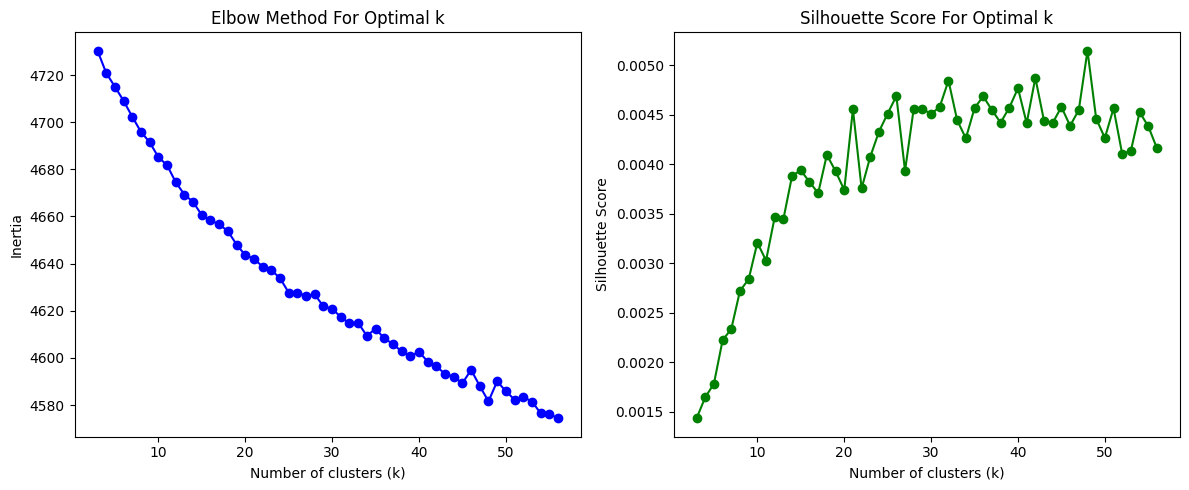

Optimal k based on silhouette score: 48
Clustering complete. Sample cluster distribution:
cluster
3     264
46    236
22    221
6     207
12    196
16    171
7     163
43    161
1     152
39    143
4     119
25    114
38    113
15    112
30    104
33    103
17    100
45     98
27     95
47     93
5      87
32     85
36     82
34     81
41     79
24     77
37     77
0      76
35     74
2      74
40     73
18     72
20     72
26     71
42     62
28     61
14     59
9      58
31     58
11     58
10     57
23     57
44     57
13     54
19     52
21     49
29     40
8      31
Name: count, dtype: int64


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Try different K values to find optimal cluster count
inertia = []
silhouette = []
K_range = range(3, 57)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, kmeans.labels_))

# Visualize Inertia (Elbow Method)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

# Visualize Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette, 'go-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.tight_layout()
plt.show()

# Get best k by silhouette score (maximize it)
optimal_k = K_range[np.argmax(silhouette)]
print(f"Optimal k based on silhouette score: {optimal_k}")

# Final KMeans with optimal_k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X)

print("Clustering complete. Sample cluster distribution:")
print(df["cluster"].value_counts())


# Recommendation Logic

In [ ]:
import ast
from sklearn.metrics.pairwise import cosine_similarity

def has_genre(genres, target):
  return any(d.get('name','').lower() == target.lower() for d in genres)

# def recommend_movies(user_text, user_genre=None, start_year=None, end_year=None, movie_region=None):
def recommend_movies(user_text, user_genre=None, start_year=None, end_year=None, user_tone=None, movie_region=None):

  #1. Parse genres only once (ideally upstream; shown here for clarity)
  if df['genres'].dtype == 'object':
    df['genres_list'] = df['genres'].apply(ast.literal_eval)
  else:
    df['genres_list'] = df['genres']

  if 'release_date' not in df.columns: # Prob can delete this
    raise ValueError("Column 'release_date' not found in df.")

  df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year

  # 2. Genre & year filtering
  mask_genre = df['genres_list'].apply(has_genre, target=user_genre)
  mask_year  = df['release_year'].between(start_year, end_year)
  subset = df[mask_genre & mask_year].copy()

  if user_tone:
    mask_tone = df['tone'] == user_tone.lower()
    subset = subset[mask_tone]

  if subset.empty:
    return pd.DataFrame(columns=['original_title', 'overview', 'similarity', 'release_year'])

  # 3. Preprocess & vectorize the user text
  user_tokens = nltk.word_tokenize(user_text)
  user_cleaned = " ".join(preprocess(user_tokens))
  user_vec     = vectorizer.transform([user_cleaned])
  user_cluster = kmeans.predict(user_vec)[0]

  # 4. Restrict to that cluster
  # subset['cluster'] = kmeans.labels_[subset.index]
  # cluster_df = subset[subset['cluster'] == user_cluster].copy()
  cluster_df = subset  # test without clustering

  # 5. Compute cosine similarities
  movie_indices = cluster_df.index
  movie_vecs    = X[movie_indices]

  sims = cosine_similarity(user_vec, movie_vecs).flatten()
  sims_scaled = sims / sims.max()
  cluster_df = cluster_df.assign(similarity=sims_scaled)


  # 7. Sort by similarity and grab top 3
  top3 = (cluster_df.sort_values(by="similarity", ascending=False).head(3))

  return top3[["original_title", "overview", "similarity", "release_year"]]


recommend_movies("Tour around the world", "Comedy", 2000, 2010, user_tone="positive")
# Tone options are 'positive', 'neutral', 'negative' based on VADER sentiment classification.

/tmp/ipython-input-1226469726.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = subset[mask_tone]


,original_title,overview,similarity,release_year
2245,The Brothers Bloom,The Brothers Bloom are the best con men in the...,1.000000,2008.0
117,Charlie and the Chocolate Factory,A young boy wins a tour through the most magni...,0.888302,2005.0
2431,My Life in Ruins,A Greek tour guide named Georgia attempts to r...,0.634929,2009.0


# Plotting using PCA Plot

In [ ]:
from sklearn.decomposition import PCA
import plotly.express as px

# 1. Compute 3D PCA
pca3 = PCA(n_components=3, random_state=42)
X3 = pca3.fit_transform(X.toarray() if hasattr(X, "toarray") else X)

# 2. Build a DataFrame for plotting
df_plot = pd.DataFrame({
    "PC1": X3[:, 0],
    "PC2": X3[:, 1],
    "PC3": X3[:, 2],
    "cluster": df["cluster"].astype(str),
    "title": df["original_title"]
})

# 3. Plot
fig = px.scatter_3d(
    df_plot,
    x="PC1", y="PC2", z="PC3",
    color="cluster",
    hover_name="title",
    title="3D PCA of Movie‑Tone Clusters"
)
fig.update_traces(marker=dict(size=4, opacity=0.7))
fig.show()

# Solution for df.size below:

In [ ]:
# df.size - Returns the Total amount of Rows x Columns = 81,566
df.size

print(df.shape)
print("\nDf.shape separates both, so there are only 4,798 rows after preprocessing")
counts = df['tone'].value_counts()
print(counts)

(4798, 17)

Df.shape separates both, so there are only 4,798 rows after preprocessing
tone
negative    2077
positive    1663
neutral     1058
Name: count, dtype: int64


In [ ]:
terms = vectorizer.get_feature_names_out()


for i, comp in enumerate(pca3.components_, start=1):
    # pair each term with its loading on PC i
    term_weights = list(zip(terms, comp))
    # sort descending for positive, ascending for negative
    term_weights.sort(key=lambda x: x[1], reverse=True)

    top_pos = term_weights[:10]
    top_neg = term_weights[-10:]

    print(f"PC{i} most POSITIVE words:")
    for term, weight in top_pos:
        print(f"  {term:20} {weight:.4f}")

    print(f"\nPC{i} most NEGATIVE words:")
    for term, weight in top_neg:
        print(f"  {term:20} {weight:.4f}")
    print("\n" + "-"*40 + "\n")

PC1 most POSITIVE words:
  new                  0.2788
  york                 0.2536
  new york             0.2527
  friend               0.1615
  school               0.1475
  love                 0.1431
  life                 0.1328
  new york citi        0.1240
  york citi            0.1240
  citi                 0.1165

PC1 most NEGATIVE words:
  battl                -0.0669
  mission              -0.0744
  team                 -0.0773
  forc                 -0.0924
  ii                   -0.1206
  world war ii         -0.1216
  war ii               -0.1226
  world war            -0.1445
  world                -0.1867
  war                  -0.2229

----------------------------------------

PC2 most POSITIVE words:
  york                 0.3867
  new                  0.3864
  new york             0.3855
  citi                 0.2436
  new york citi        0.2084
  york citi            0.2084
  war                  0.1117
  world                0.1039
  world war            0.0649
 

# **EXPLORATORY DATA ANALYSIS (EDA)**

/tmp/ipython-input-4127947209.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




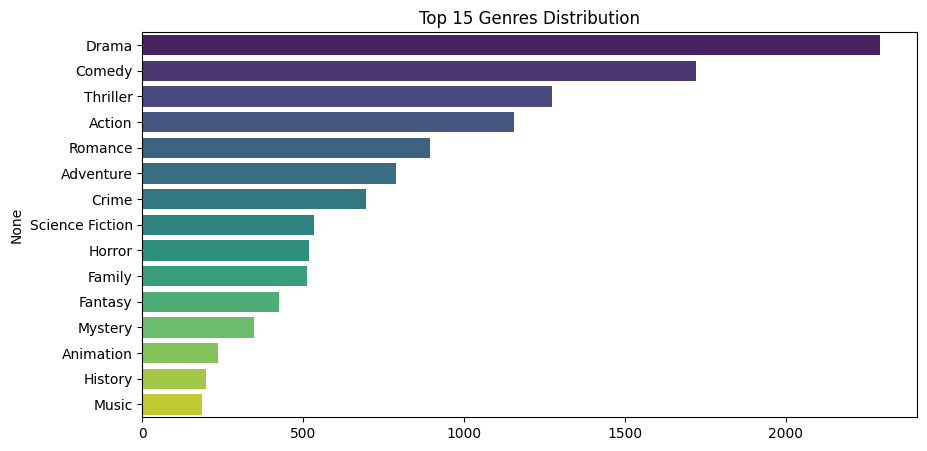

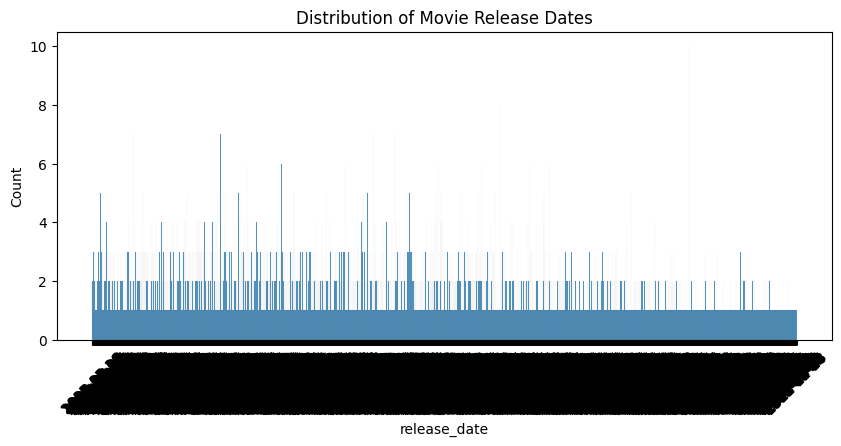

/tmp/ipython-input-4127947209.py:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




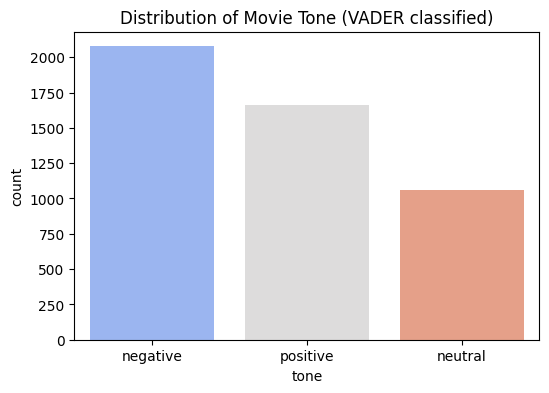

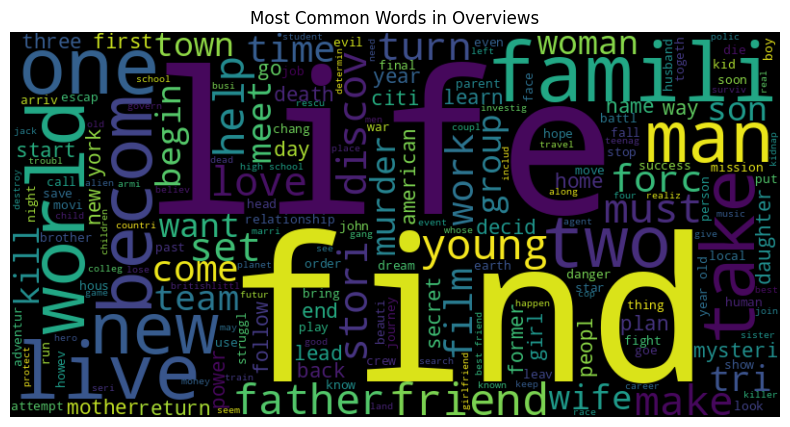

In [ ]:
def extract_genre_names(genre_str):
    genres = ast.literal_eval(genre_str)
    return [g['name'] for g in genres]

df['genre_list'] = df['genres'].apply(extract_genre_names)
all_genres = [g for genre_list in df['genre_list'] for g in genre_list]

genre_counts = pd.Series(all_genres).value_counts().head(15)

plt.figure(figsize=(10,5))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")
plt.title("Top 15 Genres Distribution")
plt.show()

# --- Release Year Distribution ---
plt.figure(figsize=(10,4))
sns.histplot(df['release_date'], bins=50, kde=False)
plt.title("Distribution of Movie Release Dates")
plt.xticks(rotation=45)
plt.show()

# --- Tone Distribution ---
plt.figure(figsize=(6,4))
sns.countplot(x='tone', data=df, palette='coolwarm')
plt.title("Distribution of Movie Tone (VADER classified)")
plt.show()

# Word cloud of overviews
from wordcloud import WordCloud
wordcloud_text = " ".join(df['clean_overview'])
wc = WordCloud(width=800, height=400, background_color="black").generate(wordcloud_text)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Overviews")
plt.show()

# Genre frequency bar chart
# Release year histogram
# Tone distribution
# Optional word cloud

# **FEATURE IMPORTANCE (TF-IDF)**

Top 15 Most Important Words (TF-IDF):
find: 0.0145
life: 0.0142
new: 0.0128
young: 0.0127
one: 0.0123
world: 0.0120
man: 0.0114
friend: 0.0111
famili: 0.0111
get: 0.0111
year: 0.0111
two: 0.0111
becom: 0.0110
live: 0.0108
stori: 0.0108


/tmp/ipython-input-2162229833.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




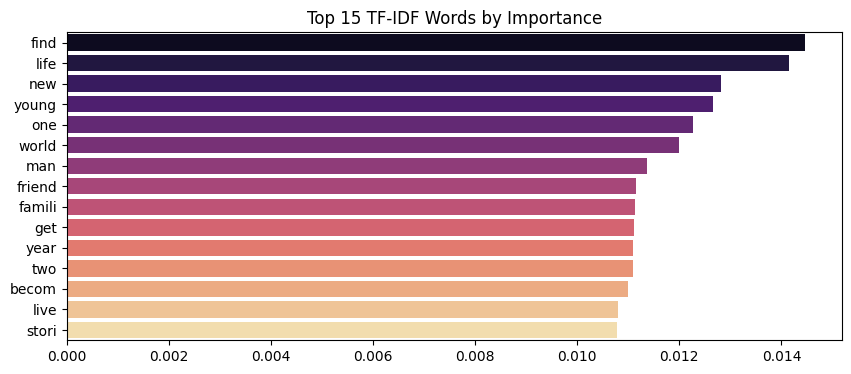

In [ ]:
# Show the top 15 most important words based on TF‑IDF overall.

# Show top 15 TF-IDF features by average importance
feature_array = np.array(vectorizer.get_feature_names_out())
tfidf_means = np.asarray(X.mean(axis=0)).flatten()
top_idx = tfidf_means.argsort()[::-1][:15]

print("Top 15 Most Important Words (TF-IDF):")
for idx in top_idx:
    print(f"{feature_array[idx]}: {tfidf_means[idx]:.4f}")

# Plot
plt.figure(figsize=(10,4))
sns.barplot(x=tfidf_means[top_idx], y=feature_array[top_idx], palette="magma")
plt.title("Top 15 TF-IDF Words by Importance")
plt.show()

# Shows which words matter most across all movie overviews.


# **MODEL EVALUATION: TONE CLASSIFIER (CONFUSION MATRIX)**

In [ ]:
from google.colab import files

files.download('tone_labels.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Loaded existing tone_labels.csv
Please upload your labeled 'tone_labels.csv' file:


Saving tone_labels.csv to tone_labels (1).csv


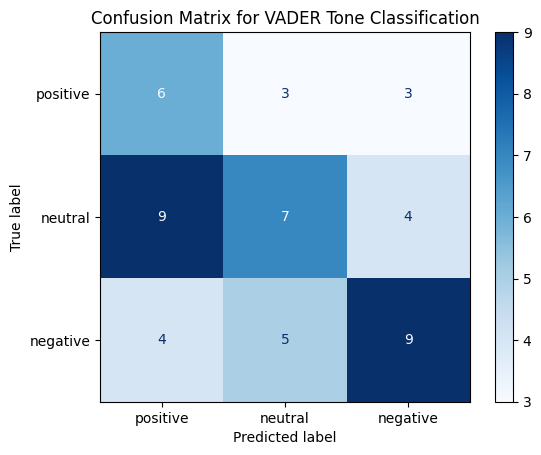

              precision    recall  f1-score   support

    negative       0.56      0.50      0.53        18
     neutral       0.47      0.35      0.40        20
    positive       0.32      0.50      0.39        12

    accuracy                           0.44        50
   macro avg       0.45      0.45      0.44        50
weighted avg       0.46      0.44      0.44        50



In [ ]:
import pandas as pd
from google.colab import files
import io
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

sample_size = 50  # number of movies to label

# Step 1: Check if labeled CSV exists
try:
    tone_eval = pd.read_csv("tone_labels.csv")
    print("Loaded existing tone_labels.csv")
except FileNotFoundError:
    # Create sample CSV for manual labeling
    sample_df = df[['original_title', 'overview', 'tone']].sample(sample_size, random_state=42)
    sample_df.rename(columns={'tone': 'predicted_tone'}, inplace=True)
    sample_df['true_tone'] = ""  # empty column for labels
    sample_df.to_csv("tone_labels.csv", index=False)
    print(f"Created tone_labels.csv with {sample_size} movies.")
    print("Please download, fill in the 'true_tone' column (positive/neutral/negative), then upload the file back here.")

    # Trigger file download
    files.download("tone_labels.csv")

    # Stop execution to let user label
    raise SystemExit("Label the file and then re-run this cell after uploading.")

# Step 2: Upload labeled CSV
print("Please upload your labeled 'tone_labels.csv' file:")
uploaded = files.upload()

# Load uploaded CSV - Get the actual filename from the uploaded dictionary
uploaded_filename = list(uploaded.keys())[0]
tone_eval = pd.read_csv(io.BytesIO(uploaded[uploaded_filename]))


# Step 3: Verify all labels are filled
if tone_eval['true_tone'].astype(str).str.strip().eq("").any():
    print("⚠️ Some 'true_tone' labels are empty. Please fill them all before evaluation.")
else:
    # Merge with main df to align predictions with true labels
    # Use the original 'tone' column from df as the predicted tone for comparison
    eval_df = df.merge(tone_eval[['original_title', 'true_tone']], on='original_title', how='inner')
    eval_df = eval_df.rename(columns={'tone': 'predicted_tone'})


    y_true = eval_df['true_tone'].str.lower()
    y_pred = eval_df['predicted_tone'].str.lower()

    labels = ['positive', 'neutral', 'negative']

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix for VADER Tone Classification")
    plt.show()

    # Classification Report
    print(classification_report(y_true, y_pred))

# **ROC/AUC + METRICS TABLE**

Macro ROC-AUC: 0.587


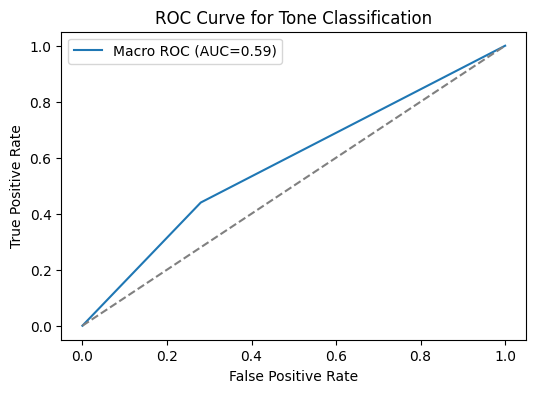

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
import itertools

try:
    # Binarize labels for ROC
    y_true_bin = label_binarize(y_true, classes=['positive','neutral','negative'])
    y_pred_bin = label_binarize(y_pred, classes=['positive','neutral','negative'])

    # ROC-AUC
    auc_score = roc_auc_score(y_true_bin, y_pred_bin, average="macro")
    print(f"Macro ROC-AUC: {auc_score:.3f}")

    # Plot ROC curve for each class
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"Macro ROC (AUC={auc_score:.2f})")
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Tone Classification")
    plt.legend()
    plt.show()

except NameError:
    print("ROC skipped (need labeled data first).")

# Gives:
# ROC-AUC score
# ROC curve visualization
